## 라이브러리

In [3]:
import numpy as np
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from collections import Counter

## 폰트 설정

In [116]:
# 폰트 사이즈
plt.rcParams['font.size'] = 25
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# 화면크기 설정
plt.rcParams['figure.figsize'] = (16,18)

## 함수 모음

In [27]:
# 나이대 분리 함수
def age_split(age):
    if age < 20 :
        result = 1
    elif age < 30 :
        result = 2
    elif age < 40 :
        result = 3
    elif age < 50 :
        result = 4
    elif age < 60 :
        result = 5
    else:
        result = 6
        
    return result

In [51]:
# 지역 분리 함수
def location_split(location):
    if location in [1,4,8]:
        result = 1 # ==> 수도권
    elif location in [6, 10, 11, 17]:
        result = 2 # 충청권
    elif location in [5, 12, 13]:
        result = 3 # 전라권
    elif location in [2, 3, 7, 14, 15]:
        result = 4 # 경상권
    elif location in [9]:
        result = 5 # 강원권
    else:
        result = 6 # 제주
    return result

In [57]:
# 특수기호 & 영어 제거
# 텍스트 한글 외 다른 것들 제거 (숫자는 포함 ex.4강...)
def text_preprocessing(text):
    text = str(text)
    sentence = text.split(' ')
    prepro_sentence = []
    for word in sentence:
        prepro_word = re.sub(r'[^가-힣0-9]', '', word)
        prepro_sentence.append(prepro_word)
        
    result = ' '.join(prepro_sentence)
    return result

In [58]:
# okt 형태소 분석기 토크나이징
def tokenize(text):
    okt = Okt()
    tokens = okt.pos(text)

#     stop_words = ['있는', '하는', '생각', '합니다', '대한', '필요', '먼저'
#              '한다', '마음', '문제', '대통령', '위해', '않는', '의견', '나라']
#     tokens = [(word, tag) for word, tag in tokens if word not in stop_words]
    
    total_words = []
    for word, tag in tokens:
        if tag not in ['Josa', 'Suffix']:
            total_words.append(word)
    result = ' '.join(total_words)
    return result

In [105]:
# 빈도분석 함수
def count_vectorize(text, vectorizer):
    word_dict = sorted(vectorizer.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}
    
    total_word = []
    total_word.append((' ').join(text.values))
    
    count_matrix = count_vectorizer.transform(total_word)
    
    count_word = []
    count_vector = []
    
    for i in range(20,0,-1):
        count_word.append(idx2word[(-count_matrix.toarray()[0]).argsort()[i-1]])
        count_vector.append(count_matrix.toarray()[0][(-count_matrix.toarray()[0]).argsort()[i-1]]) 
    
    return count_word, count_vector

In [ ]:
# tf-idf 분석
def tfidf_data(text_data, stop_word, tfidf):
    _tokeniz = text_data.map(tokenize)
    
    _word = []
    for sentence in [text for text in _tokeniz.values]:
        for word in sentence.split(' '):
            if word not in stop_word:
                _word.append(word)
                
    _total_word = []
    _total_word.append(' '.join(_word))

    _tfidf_matrix = tfidf.transform(_total_word)
    
    # 단어사전 정렬
    word_dict = sorted(tfidf.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}
    
    _tfidf_word = []
    _tfidf = []
    for i in range(25,0,-1):
        _tfidf_word.append(idx2word[(-_tfidf_matrix.toarray()[0]).argsort()[i-1]])
        _tfidf.append(_tfidf_matrix.toarray()[0][(-_tfidf_matrix.toarray()[0]).argsort()[i-1]])

    return _tfidf_word, _tfidf

In [167]:
# 가로 막대 그래프 그리기
def count_graph(word, vector, color, title):
    plt.barh(word, vector, label='단어 빈도', color=color)
    plt.ylabel('단어')
    plt.xlabel('빈도')
    plt.legend()
    plt.yticks(word)
    plt.title('{} 텍스트 빈도 분석 Top20'.format(title))
    plt.tight_layout()
    plt.savefig('{}.png'.format(title))
    plt.show()

## 데이터 불러오기

In [5]:
path = './2_올림픽에서 가장 인상 깊었던 것_30591.xlsx'
df = pd.read_excel(path, sheet_name=0)
df

,NO,UID,START,END,TIME,Q1,Q2t1,Q2t2,Q2_1,HQ_Q2_1,Q3t1
0,1000006,C327036214_1-4-4-orsiuqoem97enw8npjjes5d4,2021/08/11-00:00:16,2021/08/11-00:00:49,00:00:33,2,2000,21,3,46,안산선수
1,1000007,C327036214_1-3-3-d94uyxnq0gtmxiylnwzph10d,2021/08/11-00:00:16,2021/08/11-00:00:52,00:00:36,1,1997,24,3,47,여자배구 4강진출
2,1000011,C327036214_1-8-8-1zk22sg9o22c136k0kmh29v7,2021/08/11-00:00:20,2021/08/11-00:00:58,00:00:38,2,1978,43,8,75,메달 못따도 즐거워하는것
3,1000010,C327036214_1-5-5-3tk4BveNZppGGFhe9xYjaUtl,2021/08/11-00:00:20,2021/08/11-00:00:59,00:00:39,1,1983,38,4,54,안봄
4,1000008,C327036214_1-4-4-333y69w5o6sfk85ttlaaz15z,2021/08/11-00:00:16,2021/08/11-00:01:06,00:00:50,2,2001,20,8,82,수영에서 아시아 기록 깬것
...,...,...,...,...,...,...,...,...,...,...,...
30586,1031602,C327036214_1-1-1-lii8dwyp46v1opx4q333qlrd,2021/08/13-09:11:07,2021/08/13-09:16:14,00:05:07,2,1995,26,3,48,"긴장감넘치는 에페 펜싱경기와 최고의 경기력을 볼 수 있었던 여자 배구, 그리고 역시..."
30587,1021545,C327036214_1-7-7-wxukm1vvghgg5cuqln8v904s,2021/08/11-16:41:40,2021/08/13-09:16:19,1900-01-01 16:34:39,1,1980,41,1,15,배구 사강 .안산의 양궁
30588,1031618,C327036214_1-7-7-jjRTZVWV4uvLUlbUlHwRONHI,2021/08/13-09:16:05,2021/08/13-09:16:38,00:00:33,1,1981,40,4,55,여자배구 한일전에서 짜릿한 역전승
30589,1031617,C327036214_1-5-5-18q23pc3kmyg11q0pkia4pvh,2021/08/13-09:15:50,2021/08/13-09:16:44,00:00:54,1,1990,31,8,77,양궁 결승전에서 끝! 이라는 외마디!


In [30]:
new_df = df.iloc[:,5:]
new_df

,Q1,Q2t1,Q2t2,Q2_1,HQ_Q2_1,Q3t1
0,2,2000,21,3,46,안산선수
1,1,1997,24,3,47,여자배구 4강진출
2,2,1978,43,8,75,메달 못따도 즐거워하는것
3,1,1983,38,4,54,안봄
4,2,2001,20,8,82,수영에서 아시아 기록 깬것
...,...,...,...,...,...,...
30586,2,1995,26,3,48,"긴장감넘치는 에페 펜싱경기와 최고의 경기력을 볼 수 있었던 여자 배구, 그리고 역시..."
30587,1,1980,41,1,15,배구 사강 .안산의 양궁
30588,1,1981,40,4,55,여자배구 한일전에서 짜릿한 역전승
30589,1,1990,31,8,77,양궁 결승전에서 끝! 이라는 외마디!


## 데이터 전처리

In [31]:
# 연령 column에서 값이 '/NA/'인 행 제거
new_df = new_df.drop(new_df[new_df['Q2t2'] == '/NA/'].index)

In [32]:
# 연령대 값 int로 바꾸기
new_df = new_df.astype({'Q2t2':'int64'})
# 결측값 확인
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30569 entries, 0 to 30590
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Q1       30569 non-null  int64 
 1   Q2t1     30569 non-null  int64 
 2   Q2t2     30569 non-null  int64 
 3   Q2_1     30569 non-null  int64 
 4   HQ_Q2_1  30569 non-null  int64 
 5   Q3t1     30566 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.6+ MB


In [33]:
# 텍스트 부분 결측치 제거 후 확인
new_df = new_df.dropna(how='any', axis=0)
new_df.isna().sum()

Q1         0
Q2t1       0
Q2t2       0
Q2_1       0
HQ_Q2_1    0
Q3t1       0
dtype: int64

In [59]:
# 텍스트 특수기호, 영어 제거
new_df['prepro_text'] = new_df['Q3t1'].map(text_preprocessing)

In [61]:
new_df['prepro_text'] = new_df['prepro_text'].map(tokenize)

### 성별

In [63]:
# 성별 데이터
# 남성
male = new_df['prepro_text'][new_df['Q1'] == 1]
# 여성
female = new_df['prepro_text'][new_df['Q1'] == 2]

### 나이별

In [34]:
# 나이 코딩 변환
new_df['Q2t2'] = new_df['Q2t2'].map(age_split)
new_df['Q2t2'].value_counts()

3    9263
2    8124
4    6172
1    3000
5    2995
6    1012
Name: Q2t2, dtype: int64

In [64]:
# 연령대 데이터
age10 = new_df['prepro_text'][new_df['Q2t2']==1]
age20 = new_df['prepro_text'][new_df['Q2t2']==2]
age30 = new_df['prepro_text'][new_df['Q2t2']==3]
age40 = new_df['prepro_text'][new_df['Q2t2']==4]
age50 = new_df['prepro_text'][new_df['Q2t2']==5]
age60 = new_df['prepro_text'][new_df['Q2t2']==6]

# 청년층 vs 장년층
age1030 = new_df['prepro_text'][new_df['Q2t2']<=3]
age4060 = new_df['prepro_text'][new_df['Q2t2']>=4]

### 지역별

In [52]:
# 지역 분리 코딩 변환
new_df['지역'] = new_df['Q2_1'].map(location_split)

In [54]:
new_df['지역'].value_counts()

1    18033
4     6698
2     2707
3     2241
5      610
6      277
Name: 지역, dtype: int64

In [65]:
# 6권역
sudo = new_df['prepro_text'][new_df['지역']==1]
choong = new_df['prepro_text'][new_df['지역']==2]
junla = new_df['prepro_text'][new_df['지역']==3]
kyungsang = new_df['prepro_text'][new_df['지역']==4]
kangwon = new_df['prepro_text'][new_df['지역']==5]
jeju = new_df['prepro_text'][new_df['지역']==6]

# 수도권 vs 비수도권
ok_sudo = new_df['prepro_text'][new_df['지역']==1]
no_sudo = new_df['prepro_text'][new_df['지역']>=2]

# 텍스트 분석

## 불용어 사전

In [217]:
stop_words = ['10', '선수', '배구', '경기', '모습', '제일', '이번' 
              '하는', '우상', '가장', '종목', '수의', '깊었다', '올림픽']

In [218]:
# 빈도분석 단어사전 정리
count_vectorizer = CountVectorizer(max_features=300, 
                                   min_df=100,
                                   ngram_range =(2,2),
                                   stop_words=stop_words).fit(new_df['prepro_text'])

### 남성

In [191]:
male_count_word, male_count_vector = count_vectorize(male, count_vectorizer)

In [192]:
for idx, val in enumerate(male_count_word):
    male_count_word[idx] = val.replace('관왕', '3관왕')

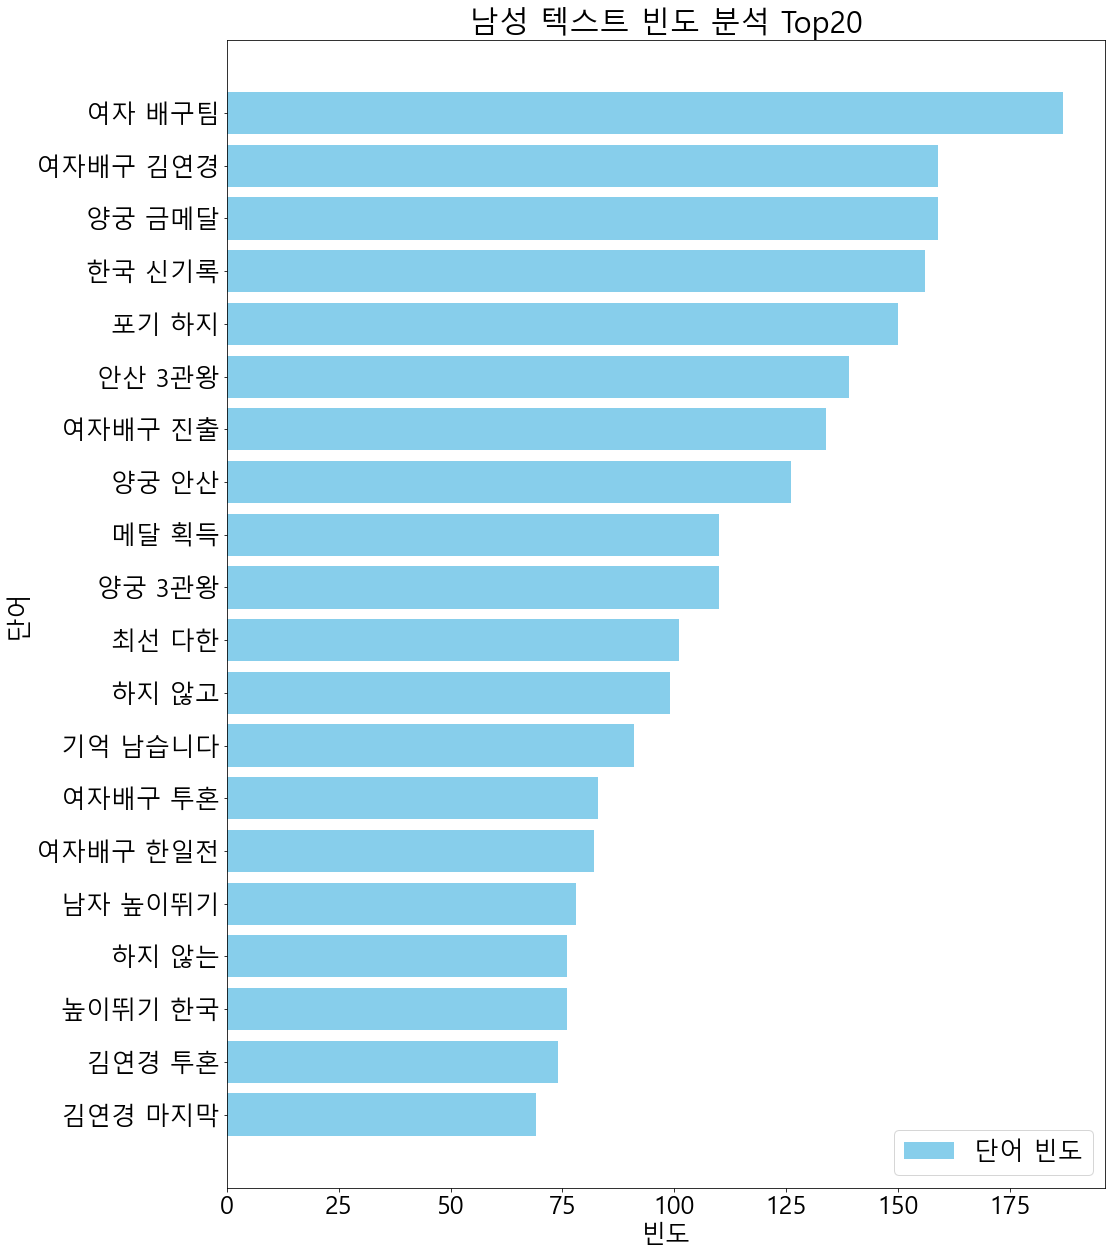

In [193]:
count_graph(male_count_word, male_count_vector, 'skyblue', '남성')

### 여성

In [196]:
female_count_word, female_count_vector = count_vectorize(female, count_vectorizer)

In [197]:
for idx, val in enumerate(female_count_word):
    female_count_word[idx] = val.replace('관왕', '3관왕')

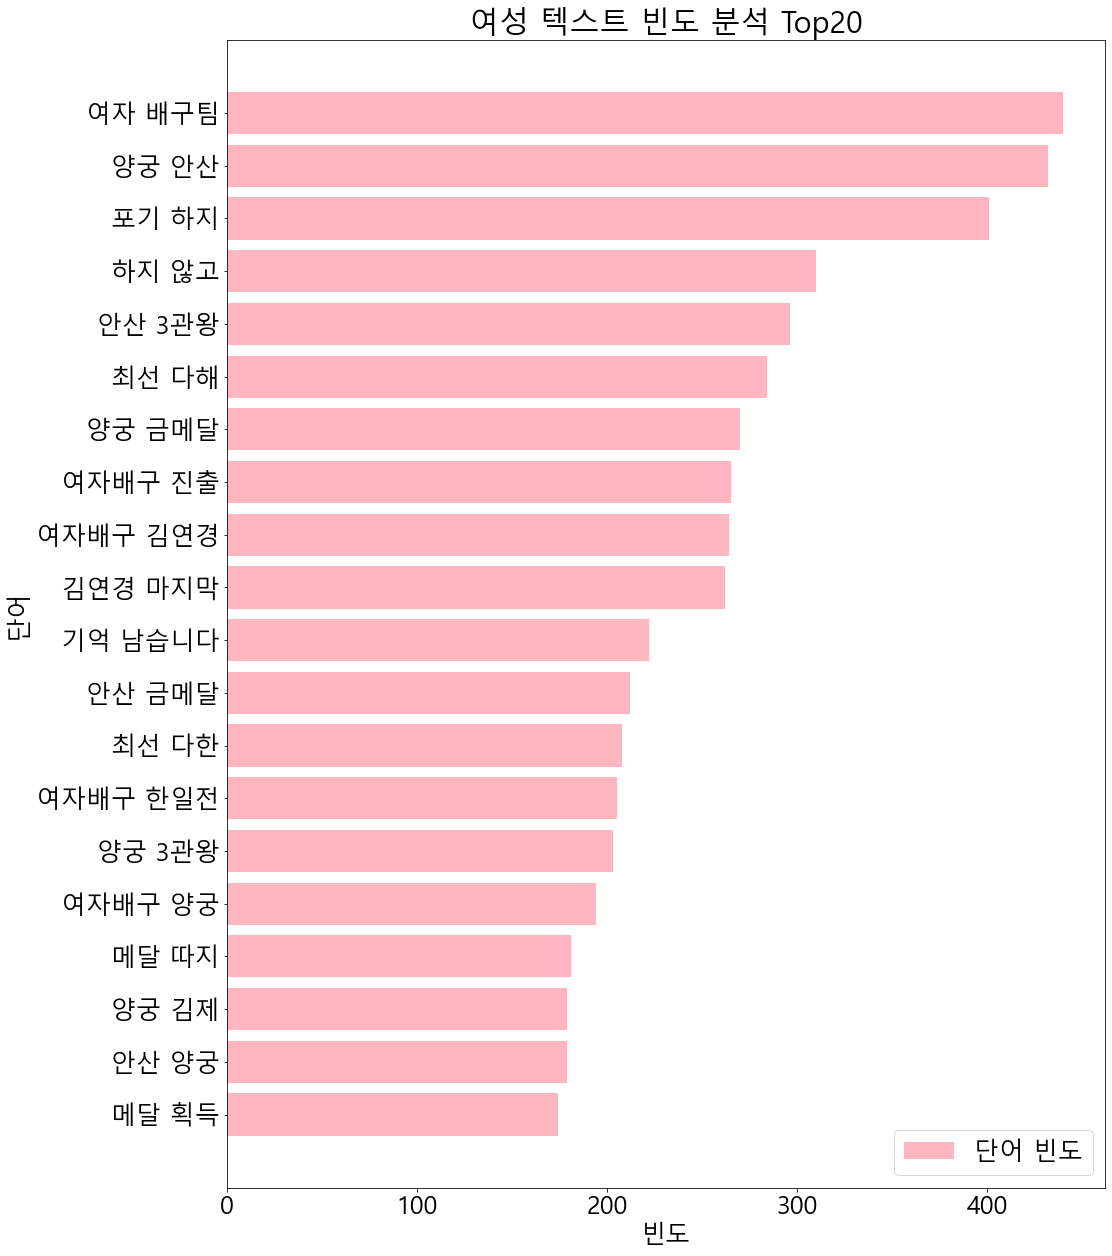

In [198]:
count_graph(female_count_word, female_count_vector, 'lightpink', '여성')

## 나이

### 청년층

In [219]:
age1030_count_word, age1030_count_vector = count_vectorize(age1030, count_vectorizer)

In [220]:
for idx, val in enumerate(age1030_count_word):
    age1030_count_word[idx] = val.replace('관왕', '3관왕')

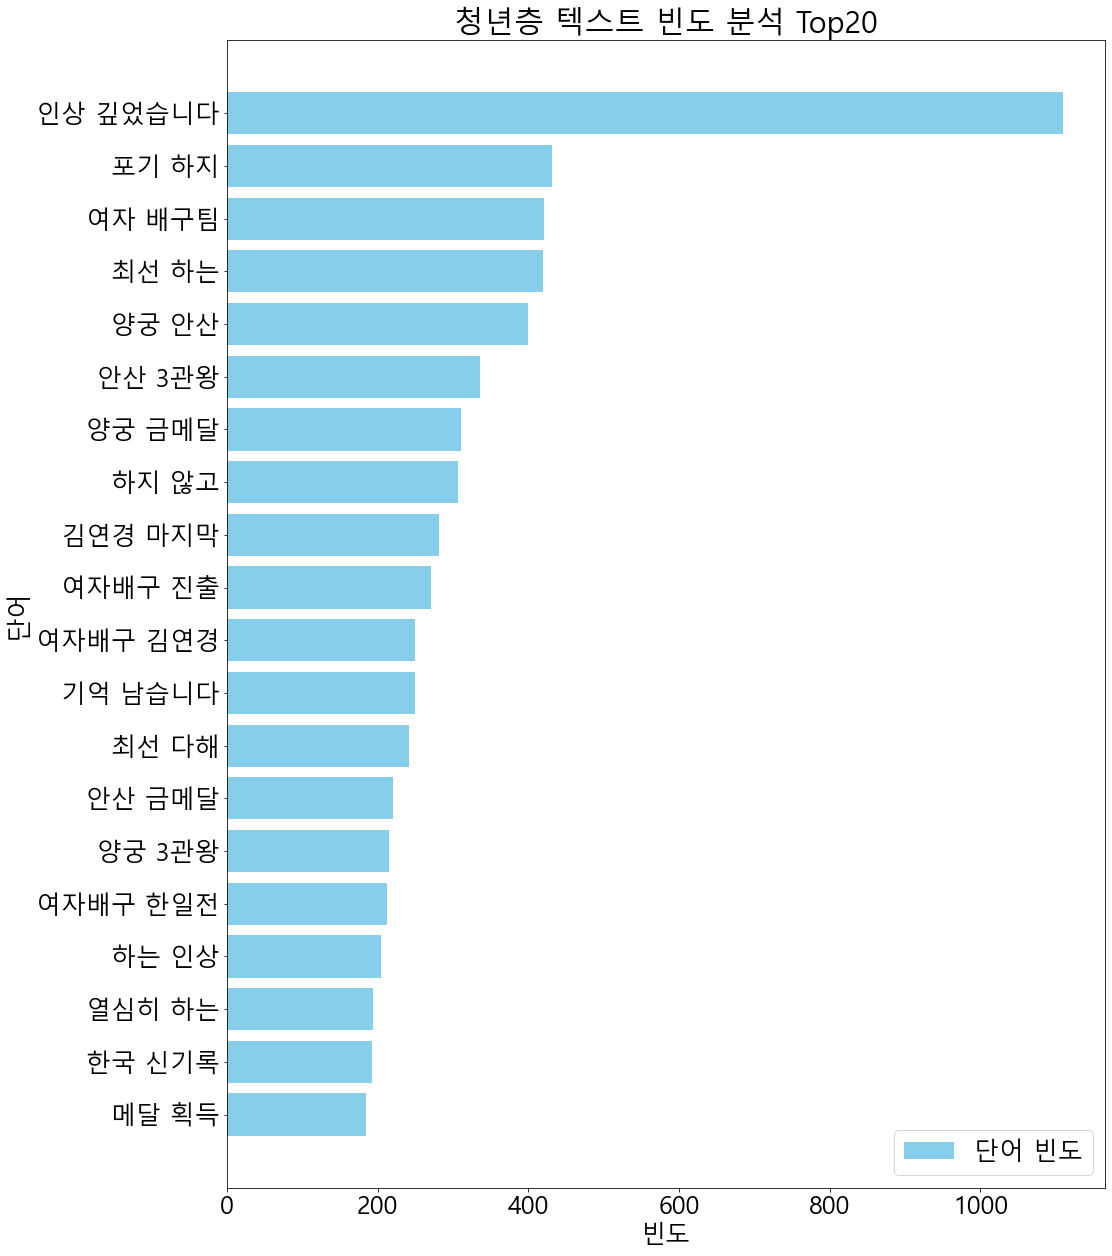

In [221]:
count_graph(age1030_count_word, age1030_count_vector, 'skyblue', '청년층')

### 중장년층

In [222]:
age4060_count_word, age4060_count_vector = count_vectorize(age4060, count_vectorizer)

In [223]:
for idx, val in enumerate(age4060_count_word):
    age4060_count_word[idx] = val.replace('관왕', '3관왕')

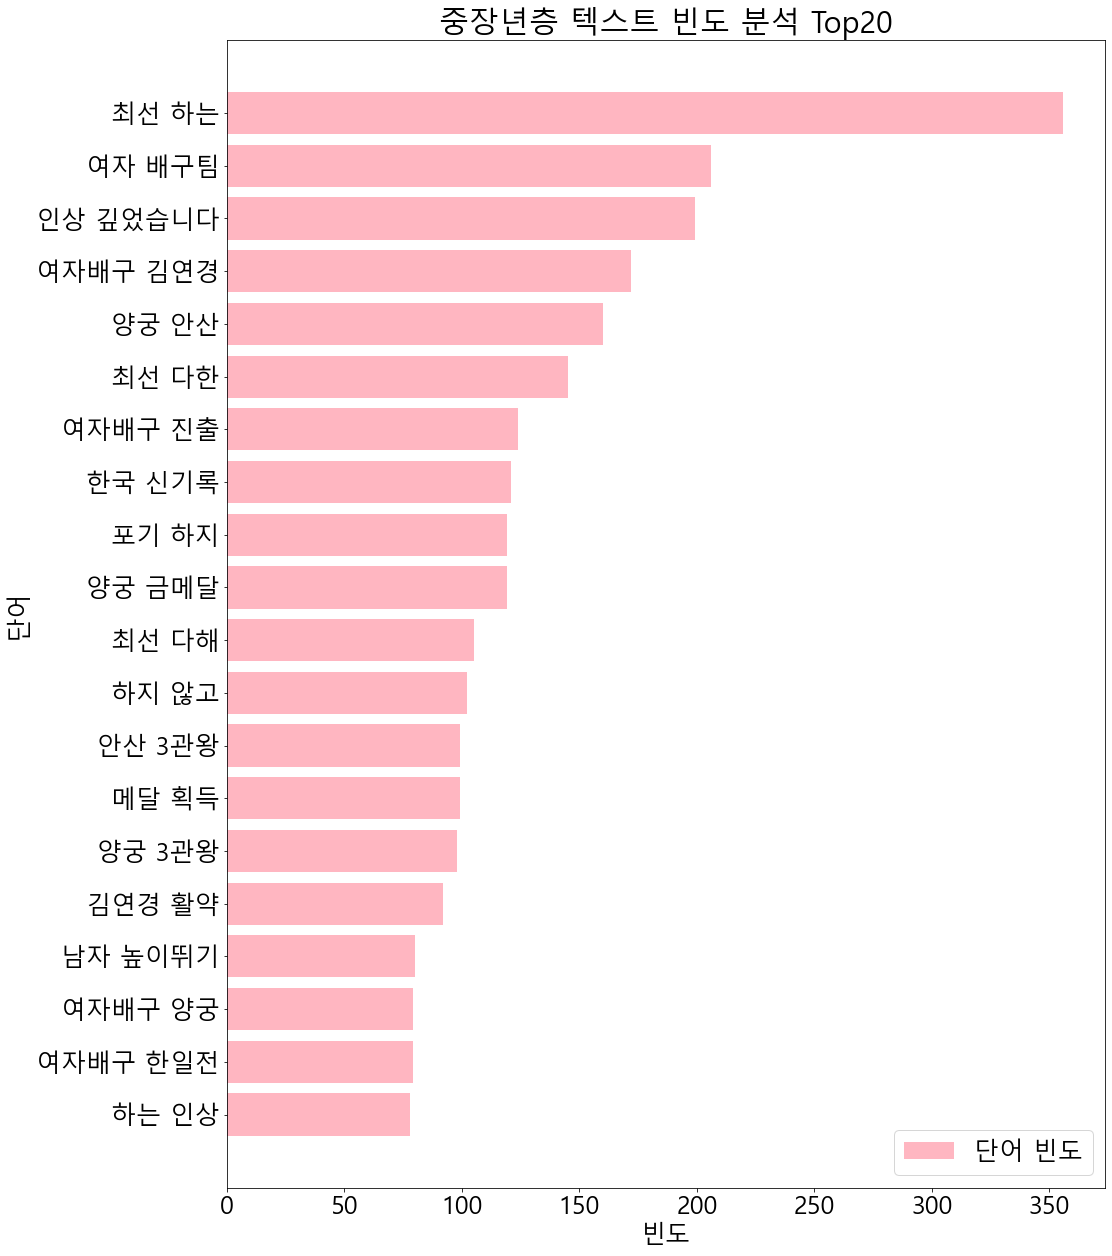

In [224]:
count_graph(age4060_count_word, age4060_count_vector, 'lightpink', '중장년층')

## 지역

### 수도권

In [225]:
ok_sudo_count_word, ok_sudo_count_vector = count_vectorize(ok_sudo, count_vectorizer)

In [226]:
for idx, val in enumerate(ok_sudo_count_word):
    ok_sudo_count_word[idx] = val.replace('관왕', '3관왕')

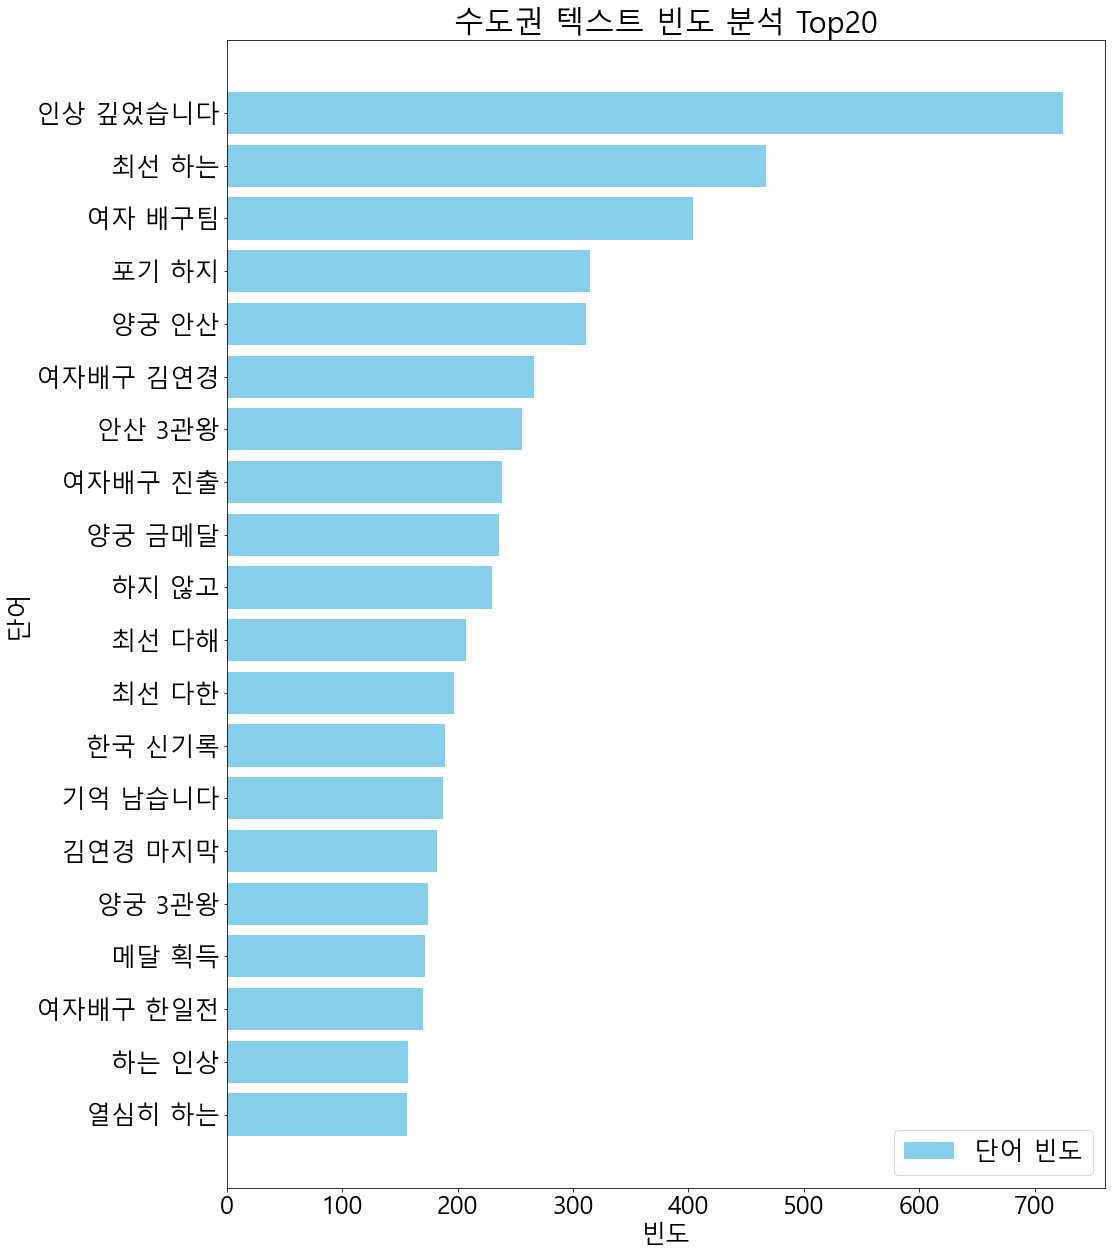

In [227]:
count_graph(ok_sudo_count_word, ok_sudo_count_vector, 'skyblue', '수도권')

### 비수도권

In [228]:
no_sudo_count_word, no_sudo_count_vector = count_vectorize(no_sudo, count_vectorizer)

In [229]:
for idx, val in enumerate(no_sudo_count_word):
    no_sudo_count_word[idx] = val.replace('관왕', '3관왕')

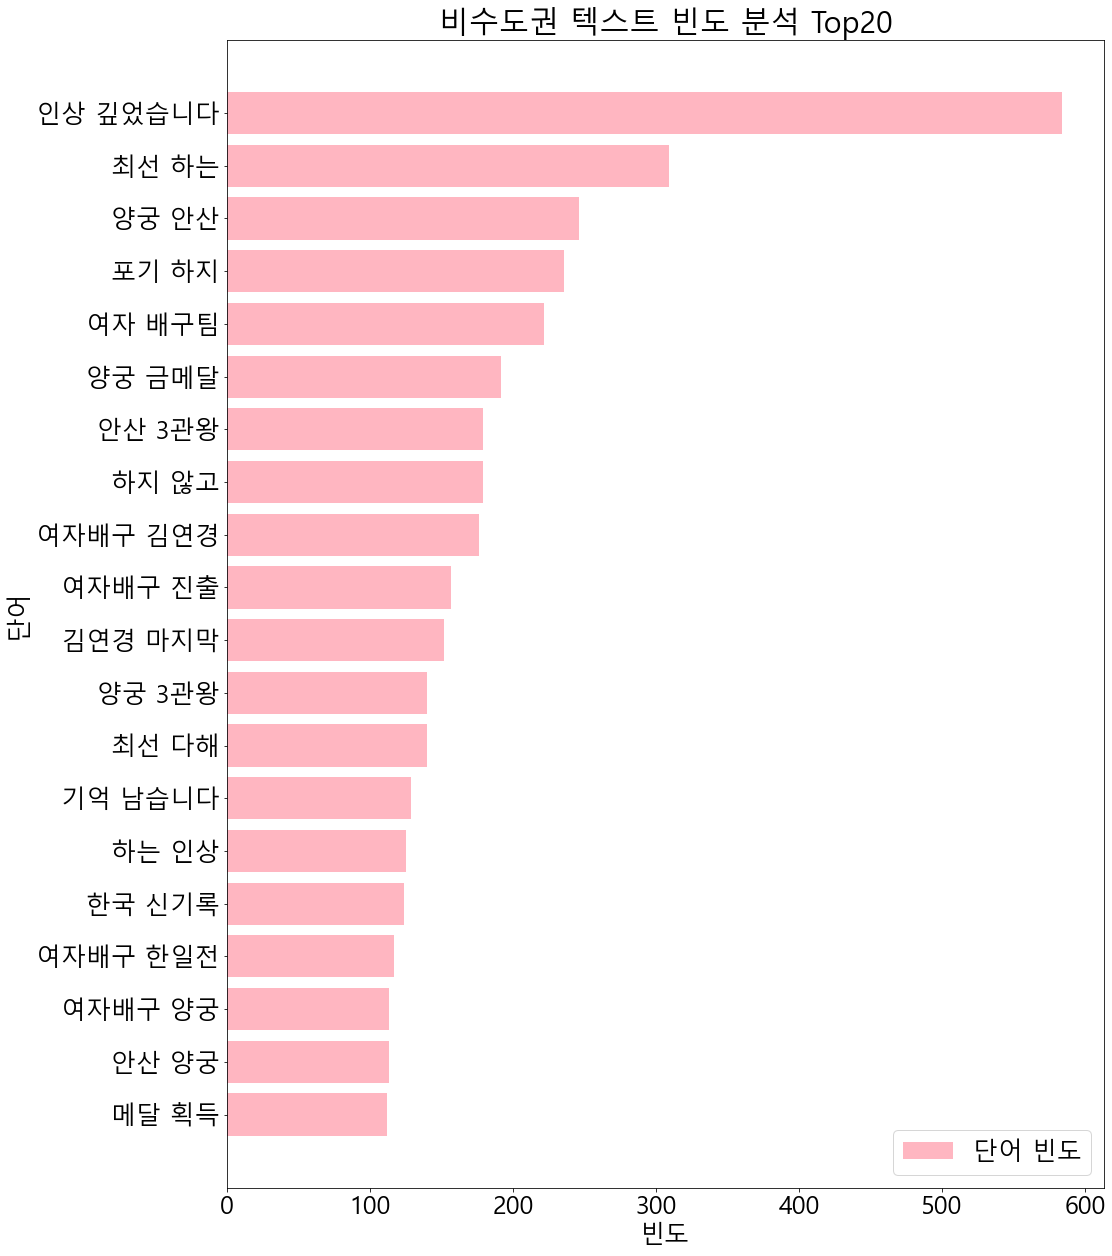

In [230]:
count_graph(no_sudo_count_word, no_sudo_count_vector, 'lightpink', '비수도권')